# Final Project: Detecting bots in wikipedia  streaming data

1) Consider all the changes done in the wikipedia as stream.
** Check here: https://wikitech.wikimedia.org/wiki/RCStream

2) Each action is received in json format. 

3) Data is full of bots. There is a flag were programmers can 
indicate that an actions has been done by a bot.

4) Using this information as ground truth, develop a system able 
to classify users as bot or human.

5) Constrain: You need to sample, and just use the 20% of 
the data stream. 

6) Describe the distribution of edits per users and bots. 

7) Finally, train a Bloom Filter that filter out bots from the stream. 

* Find the correct parameters for the bloom filter having an 
error below 10%.

8) If you want to have a 100% you need to do this:

* Make your system to work with Spark Streaming (5%)

In [ ]:
from sseclient import SSEClient as EventSource
import time
import json

In [69]:
# Define helper functions

def fetch_raw(event_source, fetching_time_sec, message_types, wikis, event_decimation=5, print_log=False):
    observed_users = set()
    skipped_users = set()
    user_counter = 0
    start_time = time.time()
    for event in event_source:
        try:
            change = json.loads(event.data)
        except:
            # ignore message
            continue

        if change["type"] not in message_types or change["wiki"] not in wikis:
            # ignore message
            continue

        elapced_time = time.time() - start_time
        if elapced_time > fetching_time_sec:
            break

        yield (change)


def hash_user(wiki, id):
    return hash((wiki, id))

def fetch_users(event_source, fetching_time_sec, message_types, wikis, event_decimation=5, print_log=False):
    observed_users = set()
    skipped_users = set()
    user_counter = 0
    start_time = time.time()
    for event in event_source:
        try:
            change = json.loads(event.data)
        except:
            # ignore message
            continue

        if change["type"] not in message_types or change["wiki"] not in wikis:
            # ignore message
            continue

        user = hash_user(change["wiki"], change["title"], change["user"])
        if user in observed_users:
            if print_log:
                print(f"Message from user {user} saved")
            save_user = True
        elif user in skipped_users:
            if print_log:
                print(f"Message from user {user} skipped")
            save_user = False
        else:
            # new user   
            if user_counter % event_decimation == 0:
                if print_log:
                    print(f"+ Add new user {user}")
                observed_users.add(user)
                save_user = True
            else:
                if print_log:
                    print(f"- Add Skip user {user}")
                skipped_users.add(user)
                save_user = False
            user_counter += 1

        elapced_time = time.time() - start_time
        if elapced_time > fetching_time_sec:
            break

        if save_user:
            yield (change)

In [57]:
url = 'https://stream.wikimedia.org/v2/stream/recentchange'
message_types = {"edit"}
wikis = {"enwiki"}#, "wikidatawiki"}
wikis_str = "_".join(wikis)

In [70]:
fetching_time_sec = 800

raw_items = [change for change in fetch_raw(EventSource(url), fetching_time_sec, message_types, wikis)]

In [92]:
raw_items[0]

{'$schema': '/mediawiki/recentchange/1.0.0',
 'meta': {'uri': 'https://en.wikipedia.org/wiki/George_Santos',
  'request_id': '7853eaf3-e784-46d0-8030-5515bea95a3e',
  'id': '04b13719-4ad1-4018-b01e-419bd9fb1edb',
  'dt': '2023-11-21T19:51:25Z',
  'domain': 'en.wikipedia.org',
  'stream': 'mediawiki.recentchange',
  'topic': 'codfw.mediawiki.recentchange',
  'partition': 0,
  'offset': 785902126},
 'id': 1696879635,
 'type': 'edit',
 'namespace': 0,
 'title': 'George Santos',
 'title_url': 'https://en.wikipedia.org/wiki/George_Santos',
 'comment': 'added link',
 'timestamp': 1700596285,
 'user': 'TheHetStopper',
 'bot': False,
 'notify_url': 'https://en.wikipedia.org/w/index.php?diff=1186232574&oldid=1186214513',
 'minor': False,
 'length': {'old': 284532, 'new': 284675},
 'revision': {'old': 1186214513, 'new': 1186232574},
 'server_url': 'https://en.wikipedia.org',
 'server_name': 'en.wikipedia.org',
 'server_script_path': '/w',
 'wiki': 'enwiki',
 'parsedcomment': 'added link'}

# Analyze bot behaviour

In [304]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(raw_items)
df['length_old'] = df.apply(lambda x: x['length']['old'], axis=1)
df['length_new'] = df.apply(lambda x: x['length']['new'], axis=1)
df['length_diff'] = df['length_new'] - df['length_old']
df['revision_diff'] = df.apply(lambda x: x['revision']['new'], axis=1) - df.apply(lambda x: x['revision']['old'], axis=1)

## split revision and length to buckets
df['length_bucket'] = df.length_diff.map(lambda x: get_bin(x, bin_width=50 ,start=df.length_diff.min()))
df['revision_bucket'] = df.revision_diff.map(lambda x: get_bin(x, bin_width=10 ,start=df.revision_diff.min()))

len(df)

1458

## Bot vs Real user edit length

In [305]:
df.sample()

,$schema,meta,id,type,namespace,title,title_url,comment,timestamp,user,...,server_name,server_script_path,wiki,parsedcomment,length_old,length_new,length_diff,revision_diff,length_bucket,revision_bucket
506,/mediawiki/recentchange/1.0.0,{'uri': 'https://en.wikipedia.org/wiki/Wikiped...,1696880645,edit,4,Wikipedia:Wikipedia Signpost/Next next issue/H...,https://en.wikipedia.org/wiki/Wikipedia:Wikipe...,,1700596557,JPxG,...,en.wikipedia.org,/w,enwiki,,4644,6131,1487,1294,576,128


(0.0, 50.0)

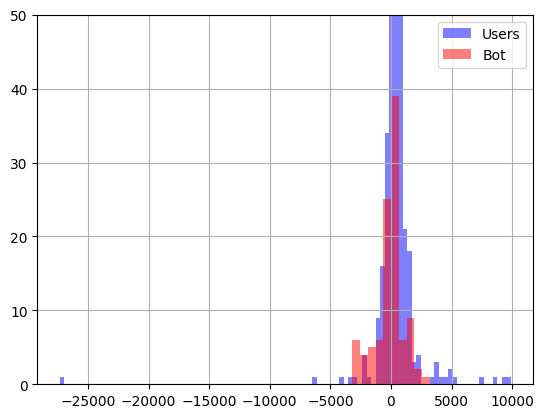

In [306]:
ax1 = plt.subplot(111)
df[~df['bot']]['length_diff'].hist(ax=ax1, color='blue', label='Users', alpha=0.5, bins=100)
df[df['bot']]['length_diff'].hist(ax=ax1, color='red', label='Bot', alpha=0.5)
ax1.legend(loc='best')

ax1.set_ylim((0, 50))

(0.0, 50.0)

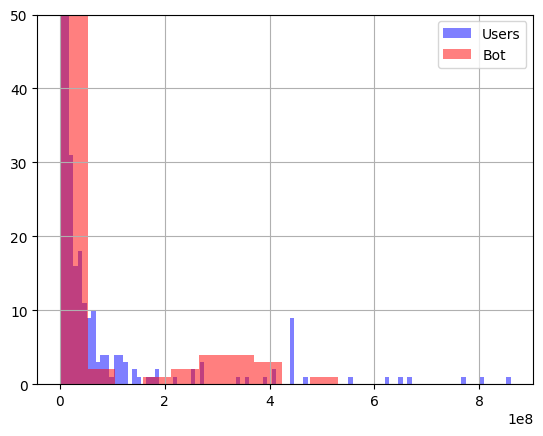

In [307]:
ax1 = plt.subplot(111)
df[~df['bot']]['revision_diff'].hist(ax=ax1, color='blue', label='Users', alpha=0.5, bins=100)
df[df['bot']]['revision_diff'].hist(ax=ax1, color='red', label='Bot', alpha=0.5)
ax1.legend(loc='best')

ax1.set_ylim((0, 50))

(-5000.0, 5000.0)

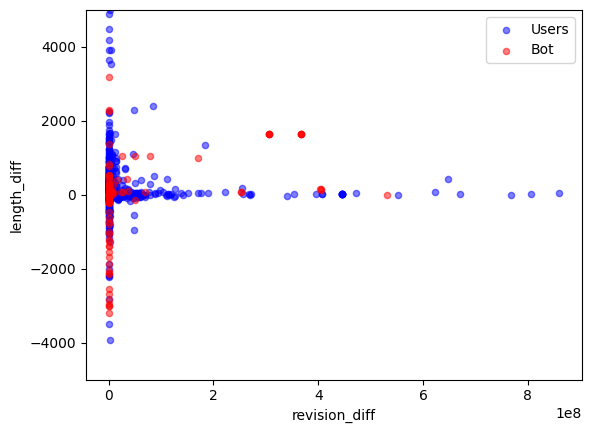

In [308]:
ax1 = plt.subplot(111)
df[~df['bot']].plot.scatter(x='revision_diff', y='length_diff', ax=ax1, color='blue', label='Users', alpha=0.5)
df[df['bot']].plot.scatter(x='revision_diff', y='length_diff', ax=ax1, color='red', label='Bot', alpha=0.5)
ax1.legend(loc='best')

ax1.set_ylim((-5000, 5000))
# ax1.set_xlim((0, 5))

Observations:
- real users makes bigger changes (>3k symbols per edit)
- changes between +/- 3k edited changes make both users and bots, so events are not distinguishable
- bots has bot in the name (too obvious)
- bots generates comments in structured form
- revision diff has significant bump from 2e-8 to 4e-8 and could be feature

## Bot behaviour

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 12.0)

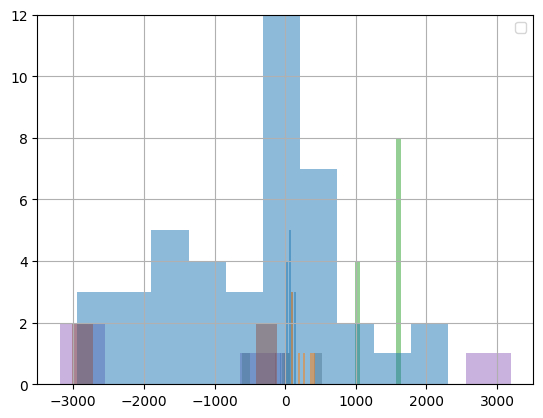

In [309]:
ax1 = plt.subplot(111)
df[df['bot']].groupby('user')['length_diff'].hist(ax=ax1, alpha=0.5)
ax1.legend(loc='best')

ax1.set_ylim((0, 12))

In [402]:
# df[df['bot']].groupby('user')['length_diff'].hist(ax=ax1, alpha=0.5)

_df = df[df['bot']].groupby(['user'], as_index=False).agg(
                      {'length_diff':['count', 'mean','std']}).reset_index()
_df.dropna(inplace=True)

_df['mahalanobis'] = _df['length_diff']['mean'] / _df['length_diff']['std']
_df

index                    user length_diff                             \
                                       count         mean           std   
1      1           Aidan9382-Bot           2    37.500000     48.790368   
2      2               AnomieBOT          53   188.641509   2324.502917   
3      3           AnomieBOT III           2  -366.000000     63.639610   
4      4                   B-bot           2   -51.000000      0.000000   
5      5                 Bot1058           3    -1.000000     15.524175   
6      6                  Cewbot          15    68.333333    196.336688   
7      7             ChristieBot          22   242.136364    519.573937   
8      8            Citation bot          88    28.227273     66.694487   
9      9             ClueBot III          17 -1096.235294  52616.314344   
10    10         CommonsDelinker           6  -212.333333    132.249260   
11    11      Community Tech bot           2     0.000000     15.556349   
12    12              Cyberbot I          13    37.153846   1689.794063   
16    16            DYKUpdateBot          12   833.916667    653.988943   
17    17                  DatBot          77    60.441558     84.251736   
18    18            DeltaQuadBot           5   194.200000    284.679996   
19    19                 DumbBOT           5   438.000000    973.897325   
20    20               EarwigBot           3  -249.333333    238.726482   
21    21          EnterpriseyBot           2    28.500000      0.707107   
22    22                  FACBot           5   258.800000    377.263436   
23    23              FireflyBot          11   793.727273     53.060514   
24    24              GalliumBot           8    25.375000     48.240284   
25    25      HBC AIV helperbot5          17  -255.352941    187.384278   
27    27            InceptionBot         211  -260.146919   2500.740015   
28    28      InternetArchiveBot          75   228.986667    137.596501   
29    29              JJMC89 bot           6   -46.500000      9.813256   
30    30          JJMC89 bot III         167   -16.245509     68.028296   
32    32                 Legobot           9    69.222222   1686.374719   
33    33               LivingBot           3     0.000000     35.028560   
34    34  Lowercase sigmabot III          20  -468.400000   3672.072517   
35    35              MajavahBot           2 -2294.500000   3543.312081   
36    36                 Mathbot           2    40.500000     57.275649   
37    37               Merge bot           3   -65.666667    371.774573   
38    38             MusikBot II           5   -19.800000      4.381780   
39    39               Mz7 (bot)           4    71.750000     52.759675   
41    41          Qwerfjkl (bot)           2    26.000000      0.000000   
42    42                RMCD bot           4 -1157.000000   1384.317160   
43    43             Reports bot          11   -14.727273     17.164445   
44    44                 RichBot           2   496.500000    403.757972   
45    45           RscprinterBot           5    37.400000     20.366639   
46    46               SDZeroBot          10  -817.100000  13129.287350   
47    47                 SineBot           2   326.500000     53.033009   
48    48              WP 1.0 bot         293  3367.948805  39424.969654   
49    49                  WugBot           2   -42.500000     92.630988   
50    50               Yapperbot           8   464.875000    786.570211   

   mahalanobis  
                
1     0.768594  
2     0.081153  
3    -5.751135  
4         -inf  
5    -0.064416  
6     0.348042  
7     0.466029  
8     0.423232  
9    -0.020835  
10   -1.605554  
11    0.000000  
12    0.021987  
16    1.275123  
17    0.717392  
18    0.682169  
19    0.449739  
20   -1.044431  
21   40.305087  
22    0.685993  
23   14.958906  
24    0.526013  
25   -1.362723  
27   -0.104028  
28    1.664190  
29   -4.738488  
30   -0.238805  
32    0.041048  
33    0.000000  
34   -0.127557  
35   -0.647558  
36    0.

In [403]:
_df = df[~df['bot']].groupby(['user'], as_index=False).agg(
                      {'length_diff':['count', 'mean','std']}).reset_index()
_df.dropna(inplace=True)

_df['mahalanobis'] = _df['length_diff']['mean'] / _df['length_diff']['std']
_df

index            user length_diff                           mahalanobis
                                 count         mean          std            
0        0    !C to the M!           2    61.000000    67.882251    0.898615
20      20   103.194.93.52           2   170.000000     8.485281   20.034692
24      24    104.151.5.98           4  4391.000000  4873.236980    0.901044
29      29   105.66.135.26           2  -630.500000   395.272691   -1.595101
37      37  108.170.65.170           2   136.500000   193.040151    0.707107
...    ...             ...         ...          ...          ...         ...
3145  3145          Zuuzzn           5    78.000000   528.783037    0.147509
3146  3146   Ânes-pur-sàng           7   124.285714    82.084741    1.514115
3147  3147      Šaholjubac           2     0.000000     0.000000         NaN
3150  3150         Векочел         108   -22.777778    31.971171   -0.712447
3151  3151         Викидим           4   321.500000   295.231548    1.088976

[1323 rows x 6 columns]

In [311]:
df[df['bot']]['user'].unique()

array(['Mz7 (bot)', 'InceptionBot', 'AnomieBOT', 'Cewbot',
       'InternetArchiveBot', 'Citation bot', 'HBC AIV helperbot5',
       'Cyberbot I', 'EarwigBot', 'DatBot', 'Bot1058', 'MusikBot',
       'FireflyBot', 'DeltaQuadBot', 'Legobot', 'RMCD bot', 'SineBot'],
      dtype=object)

In [312]:
df[df['bot']]['comment'].sample(20).unique()

array(['most recent scoring', 'Updating requested pagemoves list',
       'Rescuing 0 sources and tagging 1 as dead.) #IABot (v2.0.9.5',
       'Updating redirect to [[:1969 Miles – Festiva De Juan Pins]] (and resolving the double redirect to [[:1969 Miles: Festiva de Juan Pins]]).  Errors? [[User:AnomieBOT/shutoff/EnDashRedirectCreator]]',
       'most recent results, added 1, removed 4, total 5',
       'Rescuing 2 sources and tagging 1 as dead.) #IABot (v2.0.9.5',
       'Removed proxy/dead URL that duplicated identifier. | [[:en:WP:UCB|Use this bot]]. [[:en:WP:DBUG|Report bugs]]. | Suggested by Graeme Bartlett | #UCB_toolbar',
       'Updating hourly data for NPP backlog size',
       'most recent results, added 26, removed 27, total 248',
       'most recent results, added 5, removed 4, total 37',
       'Updating page triage stats: 10391 articles unreviewed ([[Wikipedia:Bots/Requests for approval/DatBot 11|BOT]] - [[User:DatBot/run/task11|disable]])',
       'most recent results,

Observations:

- The bot title and comment seems to be significant features

# Collect data for model training

In [313]:
# fetching_time_sec = 30000
# url = 'https://stream.wikimedia.org/v2/stream/recentchange'
# message_types = {"edit"}
# wikis = {"enwiki"}#, "wikidatawiki"}
# wikis_str = "_".join(wikis)

# with open('sample1.jsonl', 'w') as fout:
#     for item in fetch_users(EventSource(url), fetching_time_sec, message_types, wikis):
#         fout.write(json.dumps(item) + "\n")


# Read data

In [315]:
with open('sample.jsonl', 'r') as fin:
    samples = list(map(json.loads, fin.readlines()))

def get_bin(x, bin_width, start=0): 
    return (x - start) // bin_width

df = pd.DataFrame(samples)

df['length_old'] = df.apply(lambda x: x['length']['old'], axis=1)
df['length_new'] = df.apply(lambda x: x['length']['new'], axis=1)
df['length_diff'] = df['length_new'] - df['length_old']
df['revision_diff'] = df.apply(lambda x: x['revision']['new'], axis=1) - df.apply(lambda x: x['revision']['old'], axis=1)

## split revision and length to buckets
df['length_bucket'] = df.length_diff.map(lambda x: get_bin(x, bin_width=50 ,start=df.length_diff.min()))
df['revision_bucket'] = df.revision_diff.map(lambda x: get_bin(x, bin_width=10 ,start=df.revision_diff.min()))

df.drop_duplicates(['user', 'title', 'comment'], inplace=True)

len(df)

11289

In [316]:
df[['user', 'bot' ,'comment']].value_counts().reset_index().sort_values('count', ascending=True)

,user,bot,comment,count
3996,Reddqueen,False,Submitting using [[WP:AFCSW|AfC-submit-wizard]],1
5335,2600:1006:B025:890E:A8AF:672:FD61:B452,False,,1
5334,2409:4062:4D02:8813:B749:D866:7924:620D,False,/* Killing */ new section,1
5333,2600:1009:B05D:21E8:5972:77A5:D17C:1CD6,False,/* Results by congressional district */,1
5332,24.44.147.86,False,/* History */,1
...,...,...,...,...
4,Векочел,False,De-link common terms ([[User:Ohconfucius/scrip...,85
3,WP 1.0 bot,True,Copying assessment table to wiki.,102
2,InceptionBot,True,most recent scoring,115
1,Onel5969,False,Disambiguating links to [[Kushan]] (link chang...,134


In [317]:
import math 
import hashlib
import mmh3 
from bitarray import bitarray 
  
  
class BloomFilter(object): 
    def __init__(self, filter_capacity, fp_error_rate):
        # number of stored items in bloom filter, spreaded between bits (mask)
        self._filter_capacity = filter_capacity
        self._fp_error_rate = fp_error_rate
        self._size = BloomFilter.calculate_size(self._filter_capacity, self._fp_error_rate)
        self._hash_functions = [
            lambda x: int.from_bytes(hashlib.sha256(x.encode('utf-8')).digest(), 'big'), 
            # mmh3.hash
        ]
        self._mask_array = [0] * self._size

    @staticmethod
    def calculate_size(items_number, fp_error_rate):
        ''' 
        Size of bit array(m) to used using formula:
        m = -(n * lg(p)) / (lg(2)^2) 
        '''        
        return int(-(items_number * (math.log(fp_error_rate) / (math.log(2) ** 2))))

    def fit(self, X, Y):
        for x, y in zip(X, Y):
            if not y:
                continue
            for hash_func in self._hash_functions:
                index = hash_func(x) % self._size
                self._mask_array[index] = 1

    def predict_one(self, item):
        for hash_func in self._hash_functions:
            index = hash_func(item) % self._size
            if not self._mask_array[index]:
                return False
        return True

    def predict(self, items):
        return [self.predict_one(item) for item in items]

In [349]:
def extract_features(item):
    return str([
        item['user'],
        # item['comment'],
        # item['length']['new'] - item['length']['old'],
    ])
def extract_label(item):
    return item['bot']


In [350]:
import numpy as np
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split

def get_train_test_random(_df, _extract_features=extract_features, _extract_label=extract_label):
    X = list(map(_extract_features, df.to_dict('records')))
    Y = list(map(_extract_label, df.to_dict('records')))
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    return X_train, X_test, Y_train, Y_test

def get_train_test_users(_df, _extract_features=extract_features, _extract_label=extract_label):
    names = df.user.unique()
    names_train = names[:int(len(names)*0.8)]
    df_train = df[df.user.isin(names_train)]
    df_test = df[~df.user.isin(names_train)]
    
    X_train = list(map(extract_features, df_train.to_dict('records')))
    Y_train = list(map(extract_label, df_train.to_dict('records')))
    
    X_test = list(map(extract_features, df_test.to_dict('records')))
    Y_test = list(map(extract_label, df_test.to_dict('records')))
    return X_train, X_test, Y_train, Y_test

In [351]:
X_train, X_test, Y_train, Y_test = get_train_test_random(df)

### Sanity check

In [345]:
model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

In [346]:
y_pred = model.predict(X_test)

In [347]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2001
        True       0.97      0.98      0.98       257

    accuracy                           1.00      2258
   macro avg       0.99      0.99      0.99      2258
weighted avg       1.00      1.00      1.00      2258



In [348]:
f1_score(Y_test, y_pred)

0.9787234042553191

It looks classifier works as bot detection by names (it remembers user name of bots).

# Configuration search

## Features

- user name
- comment
- edit size
- revision diff
- edit + revision diff

### user name

use split by users

In [352]:
def extract_features(item):
    return item['user']

def extract_label(item):
    return item['bot']

X_train, X_test, Y_train, Y_test = get_train_test_users(df, _extract_features=extract_features, _extract_label=extract_label)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.0

### comment 

In [376]:
def extract_features(item):
    return item['comment']

def extract_label(item):
    return item['bot']


#### Split randomly

In [377]:
X_train, X_test, Y_train, Y_test = get_train_test_random(df, _extract_features=extract_features, _extract_label=extract_label)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.680672268907563

#### Split by user

In [378]:
X_train, X_test, Y_train, Y_test = get_train_test_users(df, _extract_features=extract_features, _extract_label=extract_label)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.0

It seems bot users uses the same comments, but different bots uses different comments. This feature is not robust and needs additional investigation and preprocessing like BoW.

### edit length

In [379]:
def extract_features(item):
    return str(item['length_diff'])

def extract_label(item):
    return item['bot']

#### Split randomly

In [374]:
X_train, X_test, Y_train, Y_test = get_train_test_random(df, _extract_features=extract_features, _extract_label=extract_label)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.189987163029525

#### Split by user

In [375]:
X_train, X_test, Y_train, Y_test = get_train_test_users(df, _extract_features=extract_features, _extract_label=extract_label)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.007005253940455342

In [340]:
## edit length bucket

def extract_features(item):
    return str(item['length_bucket'])
    
def extract_label(item):
    return item['bot']

X_train = list(map(extract_features, df_train.to_dict('records')))
Y_train = list(map(extract_label, df_train.to_dict('records')))

X_test = list(map(extract_features, df_test.to_dict('records')))
Y_test = list(map(extract_label, df_test.to_dict('records')))

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)


0.005917159763313609

### revision diff

In [370]:
def extract_features(item):
    return str(item['revision_diff'])

def extract_label(item):
    return item['bot']

#### Split randomly

In [371]:
X_train, X_test, Y_train, Y_test = get_train_test_random(df, _extract_features=extract_features, _extract_label=extract_label)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.2923076923076923

#### Split by user

In [372]:
X_train, X_test, Y_train, Y_test = get_train_test_users(df, _extract_features=extract_features, _extract_label=extract_label)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.02197802197802198

### revision diff bucket

In [380]:


def extract_features(item):
    return str(item['revision_bucket'])

def extract_label(item):
    return item['bot']


In [381]:
#### Split randomly

In [382]:
X_train, X_test, Y_train, Y_test = get_train_test_random(df, _extract_features=extract_features, _extract_label=extract_label)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.33333333333333337

In [383]:
#### Split by user

In [384]:
X_train, X_test, Y_train, Y_test = get_train_test_users(df, _extract_features=extract_features, _extract_label=extract_label)

model = BloomFilter(np.sum(Y_train), 0.01)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

f1_score(Y_test, y_pred)

0.023121387283236997

### Conclusions

- we observe significant gap between f1-scores depending on dataset split strategy: random split and per user split.
- Such a small scores for per user split strategy (considering Bloom filter specifics) were cased by small sample (only 3205 users contains in dataset, 51 users are bots). To increase scores we should increase test size
- there are few potential interesting features: comments and revision diff bucket that could be used for bot training.
- numbers bucketing improves performance of the model comparing to using actual numeric values. This idea matches with Bloom filter intuition but mask is generated depending on the value and is comparable (close values has higher chance to have the same hash sum)

## Parameters finetuning

There are few Bloom filter's parameters to finetune:
- filter capacity
- FP rate

Let's use comment as primary feature and find the best parameters to maximize f1 score for per-user split

In [391]:
def extract_features(item):
    return item['comment']

def extract_label(item):
    return item['bot']


X_train, X_test, Y_train, Y_test = get_train_test_users(df, _extract_features=extract_features, _extract_label=extract_label)

results = []

for item_count in [1, np.sum(Y_train)//50, np.sum(Y_train)//20, np.sum(Y_train)//10, np.sum(Y_train)/2, np.sum(Y_train)]:
    for fp_rate in [0.01, 0.05, 0.1, 0.2, 0.3]:

        model = BloomFilter(item_count, fp_rate)
        model.fit(X_train, Y_train)

        y_pred = model.predict(X_test)
        results.append({
            'fp_rate': fp_rate,
            'item_count': item_count,
            'f1_score': f1_score(Y_test, y_pred)
        })
pd.DataFrame(results).sort_values('f1_score', ascending=False)

,fp_rate,item_count,f1_score
21,0.05,610.0,0.025641
24,0.30,610.0,0.010811
17,0.10,122.0,0.009615
10,0.01,61.0,0.009615
18,0.20,122.0,0.008837
15,0.01,122.0,0.008439
12,0.10,61.0,0.007519
13,0.20,61.0,0.007109
6,0.05,24.0,0.006711
14,0.30,61.0,0.006565


The best score we can get for item numbers 610 and fp_rate = 5%

In [404]:
model = BloomFilter(610, 0.05)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

       False       1.00      0.92      0.96       929
        True       0.01      0.33      0.03         3

    accuracy                           0.92       932
   macro avg       0.51      0.63      0.49       932
weighted avg       0.99      0.92      0.95       932

